In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from __future__ import unicode_literals

In [5]:
import sys
import os

In [6]:
sys.path.append('..')

In [40]:
import networkx as nx
import numpy as np
import pandas as pd
from toolz import pipe, map, curry, unique

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import matplotlib

In [12]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('font', family='Arial')
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [11]:
%aimport classifier

In [6]:
from toolz.curried import map
from toolz.functoolz import pipe
from toolz.itertoolz import unique

In [13]:
trace_recast = 'wdm-default-filter'
trace_recastd = 'wdm'

In [19]:
recast_path = '../recast_class/' + trace_recast
recastd_path = '../recastd_class/' + trace_recastd

In [20]:
p_rnd = [1e-6, 1e-5, 1e-4, 1e-3,]

In [21]:
def build_graph(fname):  
    return nx.parse_edgelist (
        open(fname, 'r'),
        nodetype=int, 
        data=(('class', int),),
        create_using=nx.Graph()
    )

This reads the files generated by *offline* recast 

base3 is the graph with the class assigned by recast when using $p_{rnd} = 10^{-3}$

In [22]:
base3 = build_graph(recast_path + os.sep + '0.001.txt')   # 10^-3
base4 = build_graph(recast_path + os.sep + '0.0001.txt')  # 10^-4
base5 = build_graph(recast_path + os.sep + '1e-05.txt')   # ...
base6 = build_graph(recast_path + os.sep + '1e-06.txt')

List every file in recastd directory. The first number is the node id and the second is the $p_{rnd}$ value used
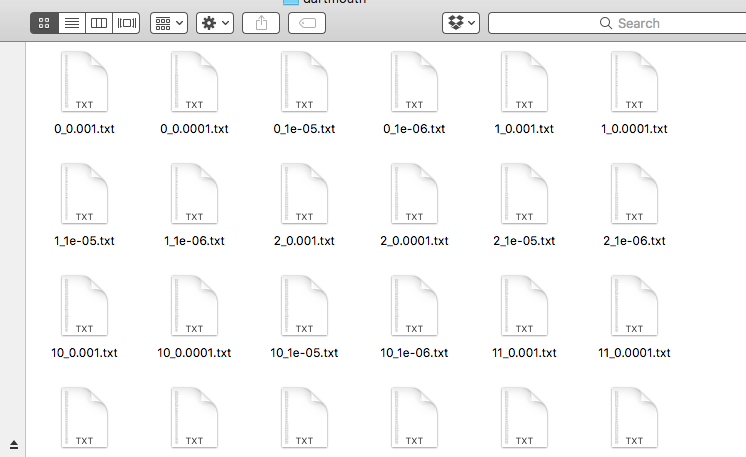

See **gen_edgelist** to see how I generate these files

In [42]:
map = curry(map)

In [66]:
recastd_files = pipe(
    os.listdir(recastd_path),
    map(lambda x: x.strip('.txt').split('_')[0]),
    unique,
    list
)

classifier*x* is a dict (edge -> class) that stores the class given by recastd for an edge

For instance, $classifier3[(1, 2)]$ = $\textbf{friends}$ means that recast**d** assigned the class **friends** for the pair $(1, 2)$ in the ego graph induced by $1$ when using $p_{rnd} = 10^{-3}$

It's valid to say that the classification is not symmetric. The class of $(x, y)$ is not always the same as $(y, x)$. This is because every node creates it's own ego graph. 

In [44]:
classifier3 = dict()
classifier4 = dict()
classifier5 = dict()
classifier6 = dict()

For every edge in each graph, store the class for that edge according to the $p_{rnd}$ value used.

In [45]:
def map_values(node, cls, graph):
    for j in graph.neighbors_iter(node):
        cls[(node, j)] = graph.get_edge_data(node, j)['class']

In [67]:
for r in recastd_files:
    graph3 = build_graph(recastd_path + os.sep + r + '_0.001.txt')
    graph4 = build_graph(recastd_path + os.sep + r + '_0.0001.txt')
    graph5 = build_graph(recastd_path + os.sep + r + '_1e-05.txt')
    graph6 = build_graph(recastd_path + os.sep + r + '_1e-06.txt')

    map_values (int(r), classifier3, graph3)
    map_values (int(r), classifier4, graph4)
    map_values (int(r), classifier5, graph5)
    map_values (int(r), classifier6, graph6)

# Optimal Classification

For every class (friends, bridges, ...) and for every $p_{rnd}$, I compute the number of optimal classifications. 

A classification is said to be optimal if for a pair of nodes $(x, y)$ the class assigned by *recast* is the same assigned by *recastd* on ego_graph$(x)$ and on ego_graph$(y)$

I only check the edges connected to the main node in the ego_graph. For instance, the main node in ego_graph(3) is (obiviously) 3. So, I will only check edges from 3 to any other node.

In [68]:
def classificacao_otima (cls, base):
    opt = dict()
    opt[classifier.friends] = 0
    opt[classifier.bridges] = 0
    opt[classifier.acquaintance] = 0
    opt[classifier.random] = 0
    
    for (x, y) in cls.iterkeys():
        assert (base.has_edge(x, y))
        c1 = cls[(x, y)]
        c2 = cls[(y, x)]
        if base.get_edge_data(x, y)['class'] == c1 == c2:
            opt[c1] += 1
    return opt

In [69]:
otimo3 = classificacao_otima (classifier3, base3)
otimo3

{0: 28714, 2: 0, 3: 0, 4: 166}

In [70]:
otimo4 = classificacao_otima (classifier4, base4)
otimo4

{0: 31268, 2: 0, 3: 0, 4: 280}

In [71]:
otimo5 = classificacao_otima (classifier5, base5)
otimo5

{0: 35382, 2: 0, 3: 0, 4: 646}

In [72]:
otimo6 = classificacao_otima (classifier6, base6)
otimo6

{0: 35382, 2: 0, 3: 0, 4: 646}

### pandas analysis

In [73]:
df = pd.DataFrame.from_dict ({
    '$10^{-3}$': otimo3,
    '$10^{-4}$': otimo4,
    '$10^{-5}$': otimo5,
    '$10^{-6}$': otimo6,
})

df = df.transpose()
df.columns = ['Random', 'Friends', 'Acquaintance', 'Bridges']

In [74]:
df['sum'] = df.sum(axis=1)
df = df.loc[:, 'Random':'Bridges'].div(df['sum'], axis=0)
df

,Random,Friends,Acquaintance,Bridges
$10^{-3}$,0.994252,0.0,0.0,0.005748
$10^{-4}$,0.991125,0.0,0.0,0.008875
$10^{-5}$,0.982070,0.0,0.0,0.017930
$10^{-6}$,0.982070,0.0,0.0,0.017930


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


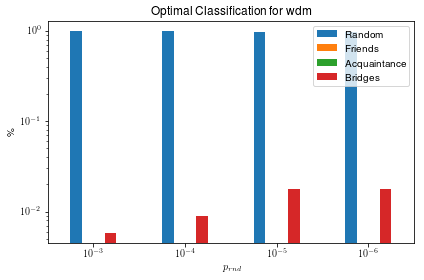

In [77]:
ax = df.plot(kind='bar', 
        logy=True, 
        title='Optimal Classification for {}'.format(trace_recastd.replace('_', '\_')),
        rot=0)

ax.set_ylabel('\%')
ax.set_xlabel('$p_{rnd}$')

fig = ax.get_figure();
# fig.savefig('images/' + trace_recastd + '/classes/optimal.png')

From the plot above, we see that most of the optimal classifications are to *random* and *bridges* classes

This is expected when nodes don't share their graph in an encounter. The reason is that $p_{rnd}$ is calculated in the random counter part of each ego graph and they are pratically the same

### To where the classes are going?

In [78]:
classes = {
    'friends': classifier.friends,
    'bridges': classifier.bridges,
    'acquaintance': classifier.acquaintance,
    'random': classifier.random,
}

In [79]:
def count_classification (cls, base):
    
    def map_classes (c):
        return {
            0: 'random',
            2: 'friends',
            3: 'acquaintance',
            4: 'bridges',
        }[c]
    
    opt = {
        'friends': {k: 0 for k in classes.keys()},
        'bridges': {k: 0 for k in classes.keys()},
        'acquaintance': {k: 0 for k in classes.keys()},
        'random': {k: 0 for k in classes.keys()},
    }
    for (x, y) in cls.iterkeys():
        assert (base.has_edge(x, y))
        
        c0 = map_classes(base.get_edge_data(x, y)['class'])
        c1 = map_classes(cls[(x, y)])
        c2 = map_classes(cls[(y, x)])
        opt[c0][c1] += 1
        opt[c0][c2] += 1
    return opt

In [80]:
count_classification(classifier3, base3)

{u'acquaintance': {u'acquaintance': 0,
  u'bridges': 0,
  u'friends': 0,
  u'random': 18444},
 u'bridges': {u'acquaintance': 0,
  u'bridges': 576,
  u'friends': 0,
  u'random': 2256},
 u'friends': {u'acquaintance': 0,
  u'bridges': 4150,
  u'friends': 0,
  u'random': 7706},
 u'random': {u'acquaintance': 8,
  u'bridges': 2,
  u'friends': 0,
  u'random': 57438}}

##### For each $p_{rnd}$...

In [81]:
def build_table(classifier, base):
    w = count_classification(classifier, base)
    df = pd.DataFrame.from_dict(w)
    df.columns = ['Recast Acquaintance', 'Recast Bridges', 'Recast Friends', 'Recast Random']
    df = df.transpose()
    df.columns = ['RD Acquaintance', 'RD Bridges', 'RD Friends', 'RD Random']
    
    # taking percentage
#     df['sum'] = df.sum(axis=1)
#     df = df.loc[:, 'RD Acquaintance':'RD Random'].div(df['sum'], axis=0)
    return df

##### for base3

In [82]:
df3 = build_table(classifier3, base3)

In [83]:
df3

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0,0,0,18444
Recast Bridges,0,576,0,2256
Recast Friends,0,4150,0,7706
Recast Random,8,2,0,57438


In the table above, The first column of each row represents the class assigned by Recast and the header (first row) is the class assigned by **Distributed Recast**. For instance, if an edge $(x, y)$ is marked as *friends* by Recast and *Acquaintance* by Distributed Recast, then we count $+1$ in the table[Recast friends][RD Acquaintance]

Note that we're are counting the same edge twice $(x, y)$ and $(y, x)$

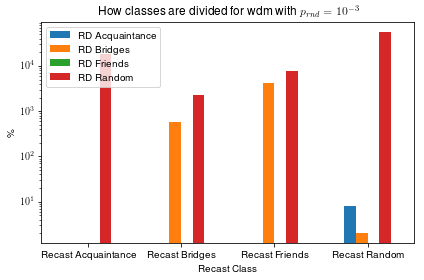

In [85]:
ax = df3.plot(kind='bar', 
              title='How classes are divided for ' + trace_recastd + ' with $p_{rnd} = 10^{-3}$',
              logy=True, 
              rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\%')

fig = ax.get_figure();
# fig.savefig('images/' + trace + '/classes/classes3.png')

##### for base4

In [86]:
df4 = build_table(classifier4, base4)

In [87]:
df4

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0,2,0,16686
Recast Bridges,0,870,0,1578
Recast Friends,0,3830,0,5038
Recast Random,8,12,0,62556


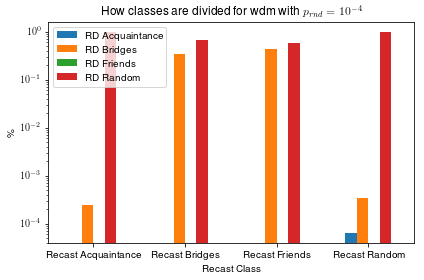

In [78]:
ax = df4.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-4}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\%')

fig = ax.get_figure();
fig.savefig('images/' + trace + '/classes/classes4.png')

##### for base5

In [57]:
df5 = build_table(classifier5, base5)

In [58]:
df5

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.00000,0.001162,0.0,0.998838
Recast Bridges,0.00000,0.498963,0.0,0.501037
Recast Friends,0.00000,0.511788,0.0,0.488212
Recast Random,0.00006,0.001510,0.0,0.998429


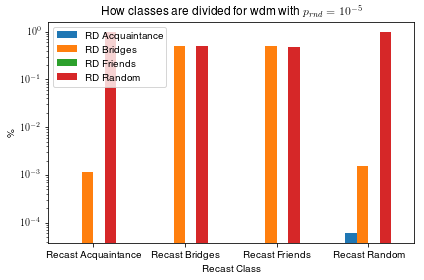

In [79]:
ax = df5.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-5}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\%')

fig = ax.get_figure();
fig.savefig('images/' + trace + '/classes/classes5.png')

##### for base6

In [60]:
df6 = build_table(classifier6, base6)

In [61]:
df6

,RD Acquaintance,RD Bridges,RD Friends,RD Random
Recast Acquaintance,0.00000,0.001162,0.0,0.998838
Recast Bridges,0.00000,0.498963,0.0,0.501037
Recast Friends,0.00000,0.511788,0.0,0.488212
Recast Random,0.00006,0.001510,0.0,0.998429


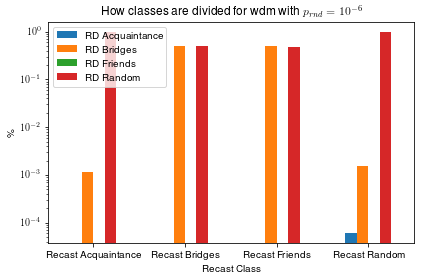

In [80]:
ax = df6.plot(kind='bar', 
         title='How classes are divided for ' + trace + ' with $p_{rnd} = 10^{-6}$',
         logy=True,
         rot=0)

ax.set_xlabel('Recast Class')
ax.set_ylabel('\%')

fig = ax.get_figure();
fig.savefig('images/' + trace + '/classes/classes6.png')